In [1]:
import os
from help_func import *
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")

### import scATAC-seq & scRNA-seq

In [2]:
ATAC_data = sc.read_h5ad('./Processed data/10X_pbmc_ATAC.h5ad')
ATAC_data

AnnData object with n_obs × n_vars = 10412 × 105949
    obs: 'celltype', 'n_genes'
    var: 'peak', 'gene', 'distance', 'peak_type', 'chr', 'from', 'to', 'n_cells'

In [3]:
RNA_data = sc.read_h5ad('./Processed data/10X_pbmc_RNA.h5ad')
RNA_data.var_names_make_unique()
RNA_data

AnnData object with n_obs × n_vars = 10412 × 21618
    obs: 'celltype', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

### filter CD14 Mono celltype

In [4]:
ATAC_data = filter_cells(ATAC_data, ATAC_data.obs[ATAC_data.obs['celltype']=='CD14 Mono'].index)
sc.pp.filter_cells(ATAC_data, min_genes=10)
sc.pp.filter_genes(ATAC_data, min_cells=1)
ATAC_data

AnnData object with n_obs × n_vars = 2789 × 105693
    obs: 'celltype', 'n_genes'
    var: 'peak', 'gene', 'distance', 'peak_type', 'chr', 'from', 'to', 'n_cells'

In [5]:
RNA_data = filter_cells(RNA_data, RNA_data.obs[RNA_data.obs['celltype']=='CD14 Mono'].index)
sc.pp.filter_cells(RNA_data, min_genes=10)
sc.pp.filter_genes(RNA_data, min_cells=1)
RNA_data

AnnData object with n_obs × n_vars = 2789 × 21306
    obs: 'celltype', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [6]:
RNA_data.var.to_csv('./Results/RNA_data_all_genes.csv')

#### import SCARP cell embedding, and clustering using Louvain

In [7]:
SCARP_cell_embedding = pd.read_csv('./Results/10X_pbmc_ATAC_SCARP_Cells_feature.csv', index_col=0)
SCARP_cell_embedding.head(2)

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40
AAACAGCCAAGGAATC-1,-0.931387,-0.282981,-0.062837,-0.139726,-0.041146,0.086365,-0.014688,-0.028159,-0.055871,0.025285,0.042060,-0.006324,-0.035705,0.018161,-0.053633,-0.000917,0.056235,0.002198,-0.022814,0.032171,0.000105,0.010370,0.025373,-0.009155,-0.010931,-0.004289,-0.000943,0.030000,0.008789,0.008502,0.003385,-0.010749,0.021449,-0.005984,0.009169,-0.029405,-0.011286,-0.005032,-0.000692,-0.016888
AAACAGCCAATCCCTT-1,-0.943546,-0.271664,-0.053141,0.021302,0.026120,-0.089000,0.022366,-0.010463,0.008320,0.002789,-0.068706,-0.039549,0.036995,-0.010293,0.026521,-0.015350,-0.050714,0.032024,-0.035068,-0.027340,-0.057199,-0.042425,0.021053,0.007473,-0.004563,0.025894,0.024325,0.026025,-0.006518,0.013862,0.029108,0.003361,0.001660,-0.015102,0.009581,0.001528,0.005388,0.002995,0.006858,0.006758


In [8]:
adata_cell = sc.AnnData(SCARP_cell_embedding.loc[RNA_data.obs.index])
adata_cell.var_names_make_unique()
sc.pp.neighbors(adata_cell, use_rep='X', random_state=1)
sc.tl.umap(adata_cell, random_state=1)

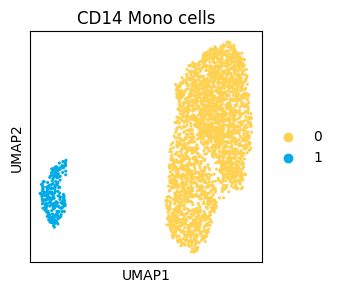

In [9]:
[warning, adata_cell] = getNClusters_Louvain(adata_cell, 2, range_max=3)
if warning == 0:
    print('Wrong for Louvain! ')
fig, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(adata_cell, color='louvain', 
           title='CD14 Mono cells', s=20, ax=ax, 
           save='_CD14_Mono_cells.svg',
           palette ={'0':'#FFD151',
                     '1':'#00ABE7'})

In [10]:
RNA_data.obs['louvain'] = adata_cell.obs['louvain'].loc[RNA_data.obs.index]
RNA_data.obsm = adata_cell.obsm

In [11]:
ATAC_data.obs['louvain'] = adata_cell.obs['louvain'].loc[ATAC_data.obs.index]
ATAC_data.obsm = adata_cell.obsm

### differential analysis for RNA

In [12]:
sc.pp.normalize_total(RNA_data)
sc.pp.log1p(RNA_data)
sc.pp.scale(RNA_data)
RNA_data

AnnData object with n_obs × n_vars = 2789 × 21306
    obs: 'celltype', 'n_genes', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_umap'

In [13]:
sc.tl.rank_genes_groups(RNA_data, 'louvain', method='wilcoxon')

In [14]:
RNA_DE_result = RNA_data.uns['rank_genes_groups']

In [15]:
RNA_DE_genes = pd.DataFrame(RNA_DE_result['names'])
RNA_DE_genes.to_csv('./Results/RNA_DE_genes.csv')

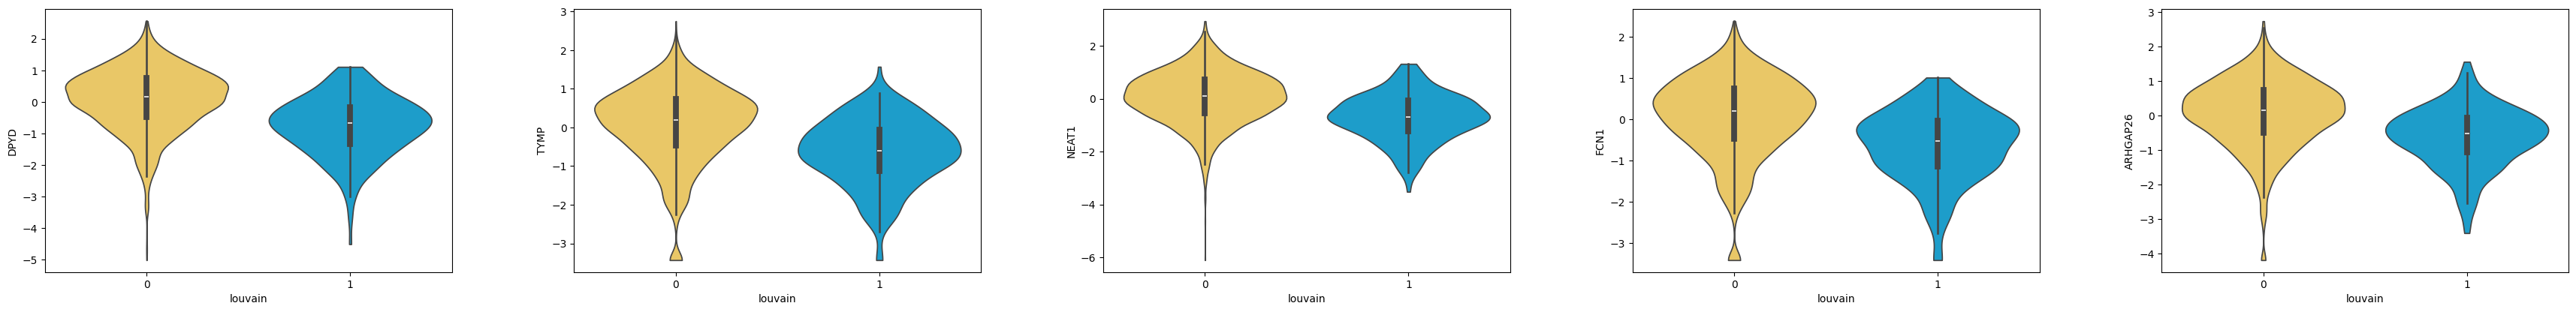

In [16]:
sc.pl.violin(RNA_data, list(RNA_DE_genes['0'].iloc[0:5]), 
             groupby='louvain', stripplot=False, inner='box',
             save='_RNA_CD14_Mono_violin_group0.svg',
             palette ={'0':'#FFD151',
                       '1':'#00ABE7'})

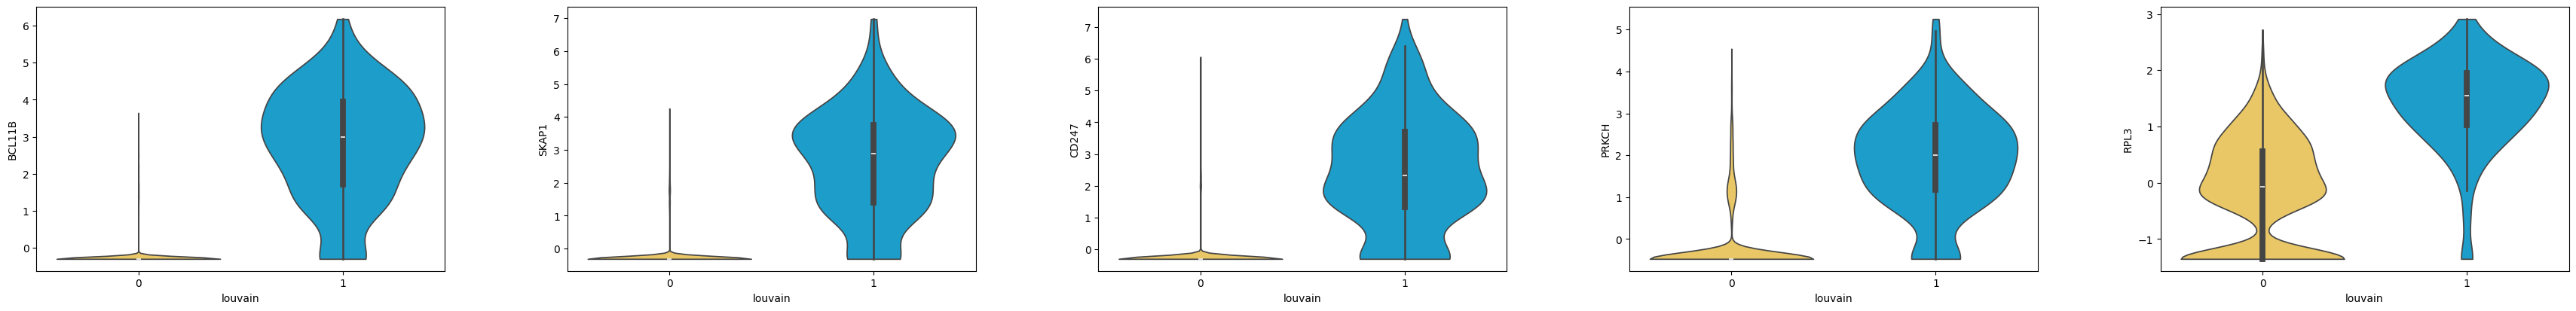

In [17]:
sc.pl.violin(RNA_data, list(RNA_DE_genes['1'].iloc[0:5]), 
             groupby='louvain', stripplot=False, inner='box',
             save='_RNA_CD14_Mono_violin_group1.svg',
             palette ={'0':'#FFD151',
                       '1':'#00ABE7'})

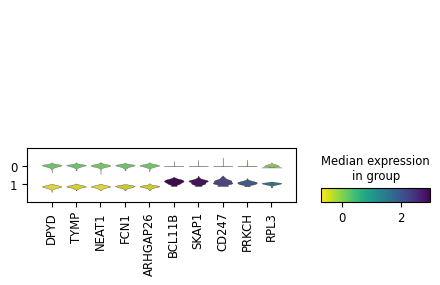

In [18]:
marker_genes = list(RNA_DE_genes['0'].iloc[0:5]) + list(RNA_DE_genes['1'].iloc[0:5])
sc.pl.stacked_violin(RNA_data, marker_genes, groupby='louvain',
                    save='_RNA_CD14Mono_marker_genes.svg',
                    cmap='viridis_r')

### differential analysis for ATAC

In [20]:
sc.pp.normalize_total(ATAC_data)
sc.pp.log1p(ATAC_data)
sc.pp.scale(ATAC_data)
ATAC_data

AnnData object with n_obs × n_vars = 2789 × 105693
    obs: 'celltype', 'n_genes', 'louvain'
    var: 'peak', 'gene', 'distance', 'peak_type', 'chr', 'from', 'to', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_umap'

In [21]:
sc.tl.rank_genes_groups(ATAC_data, 'louvain', method='wilcoxon')

In [22]:
ATAC_DE_result = ATAC_data.uns['rank_genes_groups']

In [23]:
ATAC_DE_peaks = pd.DataFrame(ATAC_DE_result['names'])
ATAC_DE_peaks.to_csv('./Results/ATAC_DE_peaks.csv')

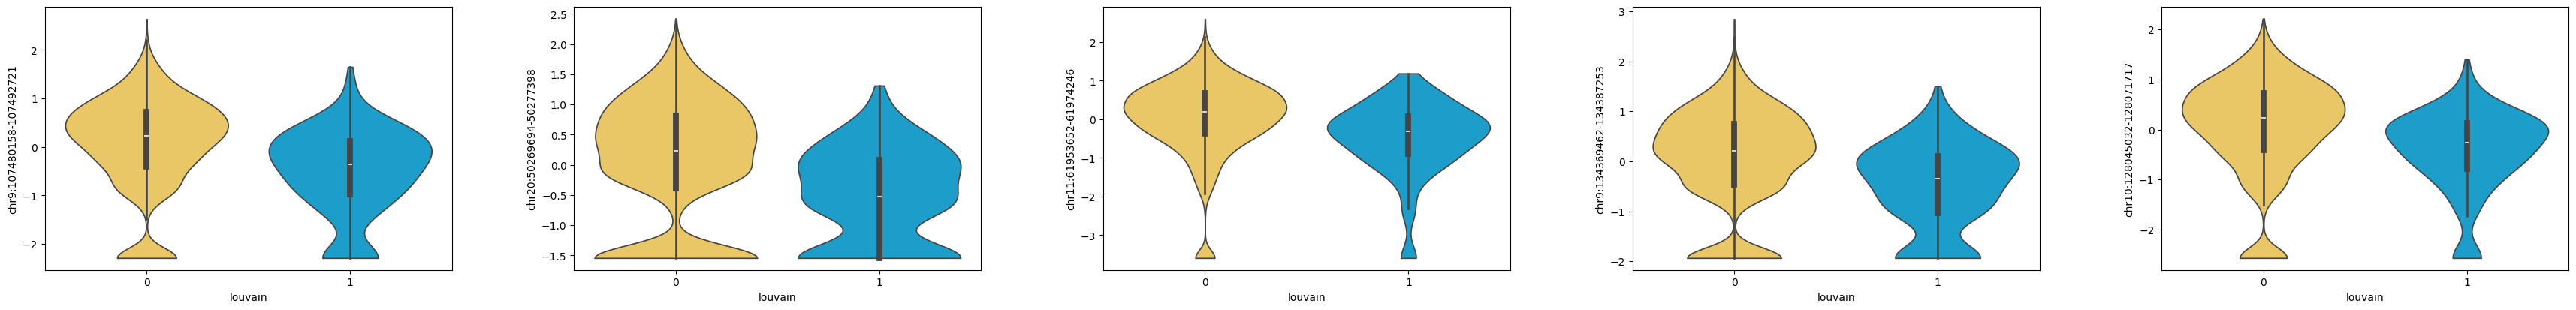

In [24]:
sc.pl.violin(ATAC_data, list(ATAC_DE_peaks['0'].iloc[0:5]), 
             groupby='louvain', stripplot=False, inner='box',
             save='_ATAC_CD14_Mono_violin_group0.svg',
             palette ={'0':'#FFD151',
                       '1':'#00ABE7'})

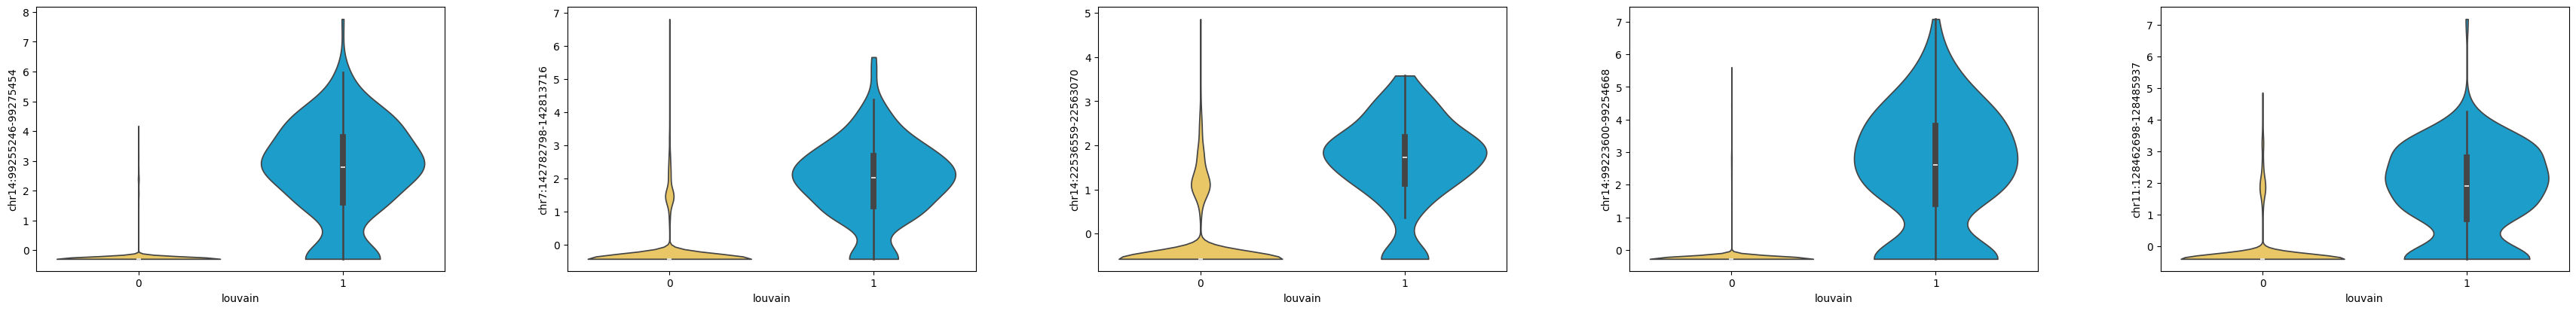

In [25]:
sc.pl.violin(ATAC_data, list(ATAC_DE_peaks['1'].iloc[0:5]), 
             groupby='louvain', stripplot=False, inner='box',
             save='_ATAC_CD14_Mono_violin_group1.svg',
             palette ={'0':'#FFD151',
                       '1':'#00ABE7'})

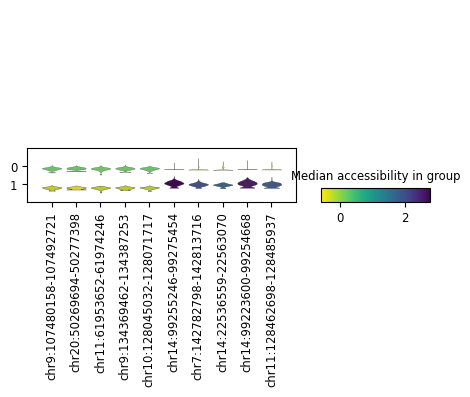

In [26]:
marker_peaks = list(ATAC_DE_peaks['0'].iloc[0:5]) + list(ATAC_DE_peaks['1'].iloc[0:5])
sc.pl.stacked_violin(ATAC_data, marker_peaks, groupby='louvain',cmap='viridis_r',
                    save='_ATAC_CD14_Mono_marker_peaks.svg',
                    colorbar_title ='Median accessibility in group')

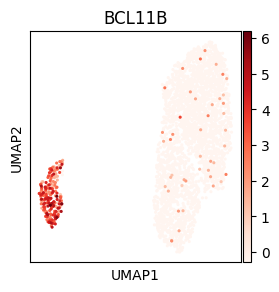

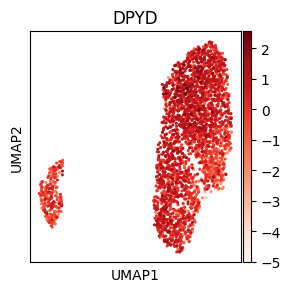

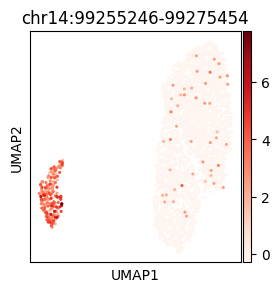

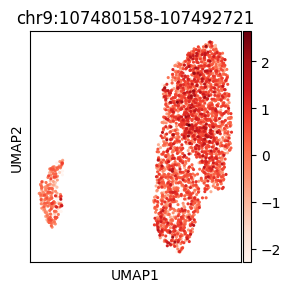

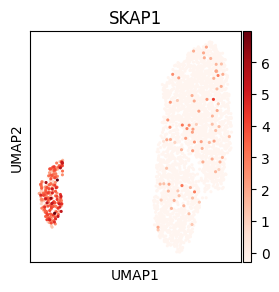

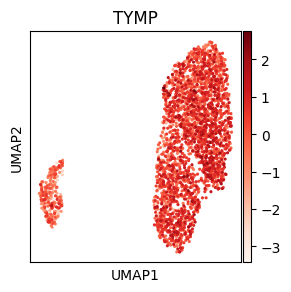

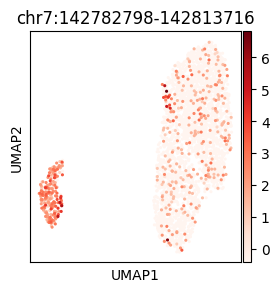

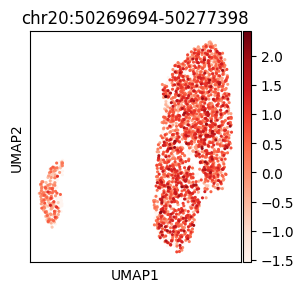

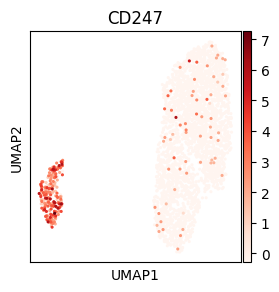

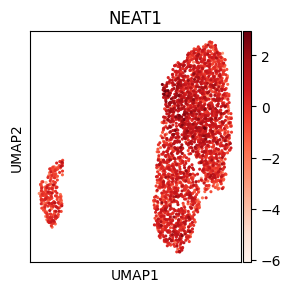

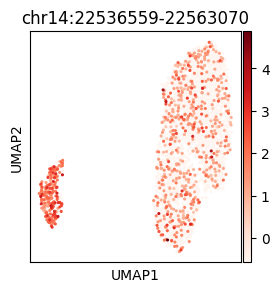

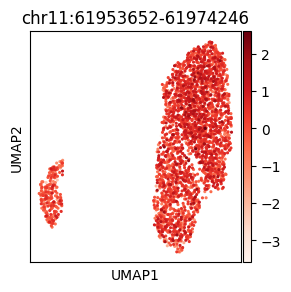

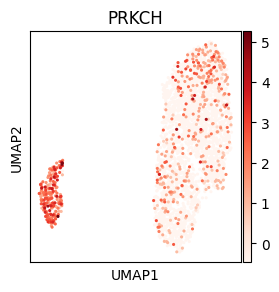

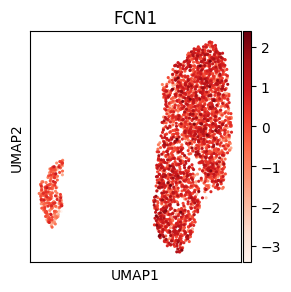

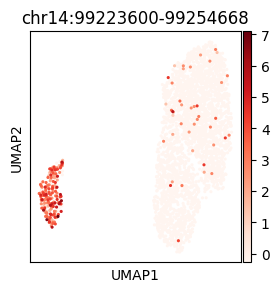

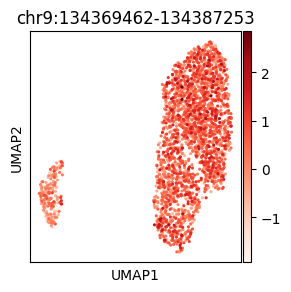

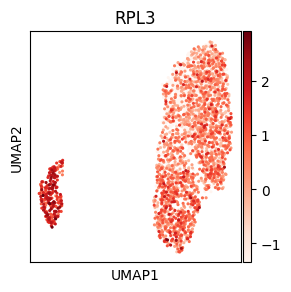

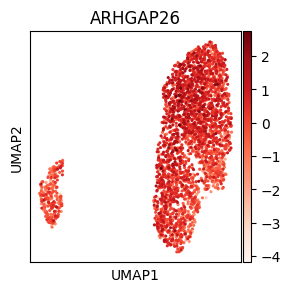

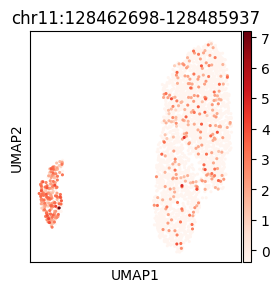

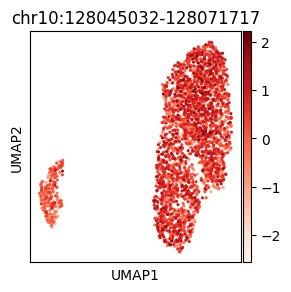

In [27]:
for i in range(5):
    fig, ax = plt.subplots(figsize=(3, 3))
    sc.pl.umap(RNA_data, color=RNA_DE_genes['1'].iloc[i],s=20, ax=ax, 
               save='_RNA_CD14_Mono_markergene1' + str(i) + '.svg',
               color_map='Reds')
    fig, ax = plt.subplots(figsize=(3, 3))
    sc.pl.umap(RNA_data, color=RNA_DE_genes['0'].iloc[i],s=20, ax=ax, 
               save='_RNA_CD14_Mono_markergene0' + str(i) + '.svg',
               color_map='Reds')
    fig, ax = plt.subplots(figsize=(3, 3))
    sc.pl.umap(ATAC_data, color=ATAC_DE_peaks['1'].iloc[i],s=20, ax=ax, 
           save='_ATAC_CD14_Mono_markerpeak1' + str(i) + '.svg',
           color_map='Reds')
    fig, ax = plt.subplots(figsize=(3, 3))
    sc.pl.umap(ATAC_data, color=ATAC_DE_peaks['0'].iloc[i],s=20, ax=ax, 
           save='_ATAC_CD14_Mono_markerpeak0' + str(i) + '.svg',
           color_map='Reds')